In [64]:
import math
from collections import deque

import torch
import torch.nn.functional as F  # noqa: N812
from torch import Tensor, nn

from lerobot.policies.pretrained import PreTrainedPolicy
from lerobot.policies.smolvla.configuration_smolvla import SmolVLAConfig
from lerobot.policies.smolvla.smolvlm_with_expert import SmolVLMWithExpertModel
from lerobot.policies.utils import (
    populate_queues,
)
from lerobot.utils.constants import ACTION, OBS_LANGUAGE_ATTENTION_MASK, OBS_LANGUAGE_TOKENS, OBS_STATE
from lerobot.utils.utils import get_safe_dtype

from lerobot.policies.segvla.configuration_segvla import SegVLAConfig
from lerobot.policies.segvla.modeling_segvla import SegVLAPolicy

In [65]:
config = SegVLAConfig()
policy = SegVLAPolicy(config)

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Reducing the number of VLM layers to 16 ...


In [7]:
import pandas as pd
from io import BytesIO
from PIL import Image, ImageFile
import torch
import numpy as np
import requests
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, MobileViTForSemanticSegmentation, SegformerForSemanticSegmentation

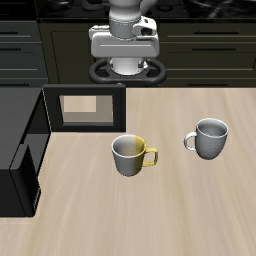

In [16]:
df = pd.read_parquet("~/.cache/huggingface/lerobot/HuggingFaceVLA/libero/data/chunk-000/file-001.parquet")
image = Image.open(BytesIO(df['observation.images.image'][0]['bytes']))
display(image)

In [62]:
df_tasks = pd.read_parquet("~/.cache/huggingface/lerobot/HuggingFaceVLA/libero/meta/tasks.parquet")
df_tasks.columns

Index(['task_index'], dtype='object')

In [31]:
ckpt = "apple/deeplabv3-mobilevit-small"
processor = AutoImageProcessor.from_pretrained(ckpt)
model = MobileViTForSemanticSegmentation.from_pretrained(ckpt)

In [9]:
ckpt2 = "nvidia/segformer-b2-finetuned-ade-512-512"
processor2 = AutoImageProcessor.from_pretrained(ckpt2)
model2 = SegformerForSemanticSegmentation.from_pretrained(ckpt2).eval()

In [10]:
def run_seg(model, image, processor):
	inputs = processor(images=image, return_tensors="pt")
	with torch.no_grad():
		outputs = model(**inputs)

	# outputs.logits: [B, num_labels, h/stride, w/stride]
	# Upsample back to original image size
	upsampled = torch.nn.functional.interpolate(
		outputs.logits,
		size=image.size[::-1],            # (H, W)
		mode="bilinear",
		align_corners=False,
	)

	# Per-pixel class IDs
	pred_ids = upsampled.argmax(dim=1)[0].cpu().numpy()     # shape (H, W)

	# Map the IDs to string labels
	id2label = model.config.id2label                         # e.g., {0: 'background', 1: 'wall', ...}
	unique_ids = np.unique(pred_ids)
	present_labels = [id2label[int(i)] for i in unique_ids]

	print("Mask shape:", pred_ids.shape)                     # per-pixel segmentation mask
	print("Labels present:", present_labels)
	num_classes = len(model.config.id2label)
	colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
	seg_image = colors[pred_ids]

	alpha = 0.9
	overlay = Image.blend(
		image.convert("RGBA"),
		Image.fromarray(seg_image).convert("RGBA"),
		alpha=alpha
	)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.title("Original Image")
	plt.imshow(image)
	plt.axis("off")

	plt.subplot(1, 2, 2)
	plt.title("Segmentation Overlay")
	plt.imshow(overlay)
	plt.axis("off")

	plt.show()
	return pred_ids


In [14]:
from scipy.ndimage import label as cc_label, center_of_mass
from matplotlib.patches import Patch

def run_seg_with_labels(model, image, processor, min_region_px=500, alpha=0.7, seed=0):
    # Preprocess and run model
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Upsample logits to image size and get per-pixel ids
    upsampled = torch.nn.functional.interpolate(
        outputs.logits, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    pred_ids = upsampled.argmax(dim=1)[0].cpu().numpy()  # (H, W)

    id2label = dict(model.config.id2label)  # ensure a real dict
    num_classes = len(id2label)

    # Stable color palette so legend matches overlay every time
    rng = np.random.default_rng(seed)
    colors = rng.integers(0, 255, size=(num_classes, 3), dtype=np.uint8)
    # Optional: force background to a light gray if id 0 is background
    if 0 in id2label and id2label[0].lower() in {"background", "bg"}:
        colors[0] = np.array([200, 200, 200], dtype=np.uint8)

    seg_rgb = colors[pred_ids]

    # Build overlay
    base = np.asarray(image.convert("RGB"))
    overlay = (alpha * seg_rgb + (1 - alpha) * base).astype(np.uint8)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].set_title("Original")
    ax[0].imshow(image)
    ax[0].axis("off")

    ax[1].set_title("Segmentation Overlay")
    ax[1].imshow(overlay)
    ax[1].axis("off")

    # Legend: one swatch per class present in the prediction
    unique_ids = np.unique(pred_ids)
    legend_handles = []
    for cid in unique_ids:
        label_name = id2label.get(int(cid), f"id {cid}")
        color = colors[int(cid)] / 255.0
        legend_handles.append(Patch(facecolor=color, edgecolor='black', label=label_name))
    ax[1].legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0,
        title="Classes"
    )

    # Per-region text labels at centroids (skip tiny blobs)
    H, W = pred_ids.shape
    for cid in unique_ids:
        # Optional: skip background
        if id2label.get(int(cid), "").lower() in {"background", "bg"}:
            continue

        class_mask = (pred_ids == cid).astype(np.uint8)
        # n_comp, comp_map = cc_label(class_mask)
        labeled_array, n_comp = cc_label(class_mask)
        if n_comp == 0:
            continue

        for comp_id in range(1, n_comp + 1):
            # comp_mask = (comp_map == comp_id)
            comp_mask = (labeled_array == comp_id)
            area = int(comp_mask.sum())
            if area < min_region_px:
                continue

            cy, cx = center_of_mass(comp_mask)
            # Guard against NaNs if region is weirdly shaped
            if not np.isfinite(cx) or not np.isfinite(cy):
                continue

            ax[1].text(
                x=float(cx),
                y=float(cy),
                s=id2label.get(int(cid), str(cid)),
                fontsize=10,
                weight="bold",
                ha="center",
                va="center",
                color="white",
                bbox=dict(boxstyle="round,pad=0.25", fc="black", ec="none", alpha=0.6)
            )

    plt.tight_layout()
    plt.show()
    return pred_ids


Mask shape: (480, 640)
Labels present: ['background', 'cat', 'sofa']


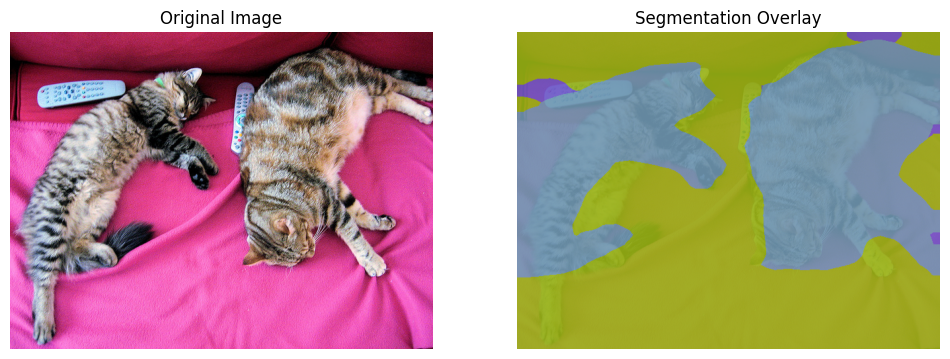

In [46]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
pred_ids = run_seg(model, image)

In [53]:
id2label = model.config.id2label  
np.unique(pred_ids)
print(id2label)

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [ ]:
from transformers import Mask2FormerForUniversalSegmentation

ckpt3 = "facebook/mask2former-swin-large-ade-semantic"
processor3 = AutoImageProcessor.from_pretrained(ckpt3)
model3 = Mask2FormerForUniversalSegmentation.from_pretrained(ckpt3).eval()

preprocessor_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

/home/ishan/miniconda3/envs/lerobot/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

In [26]:
for i in range(5, 10):
	image = Image.open(BytesIO(df['observation.images.image'][i]['bytes']))
	run_seg_with_labels(model3, image, processor3)

AttributeError: 'Mask2FormerForUniversalSegmentationOutput' object has no attribute 'logits'

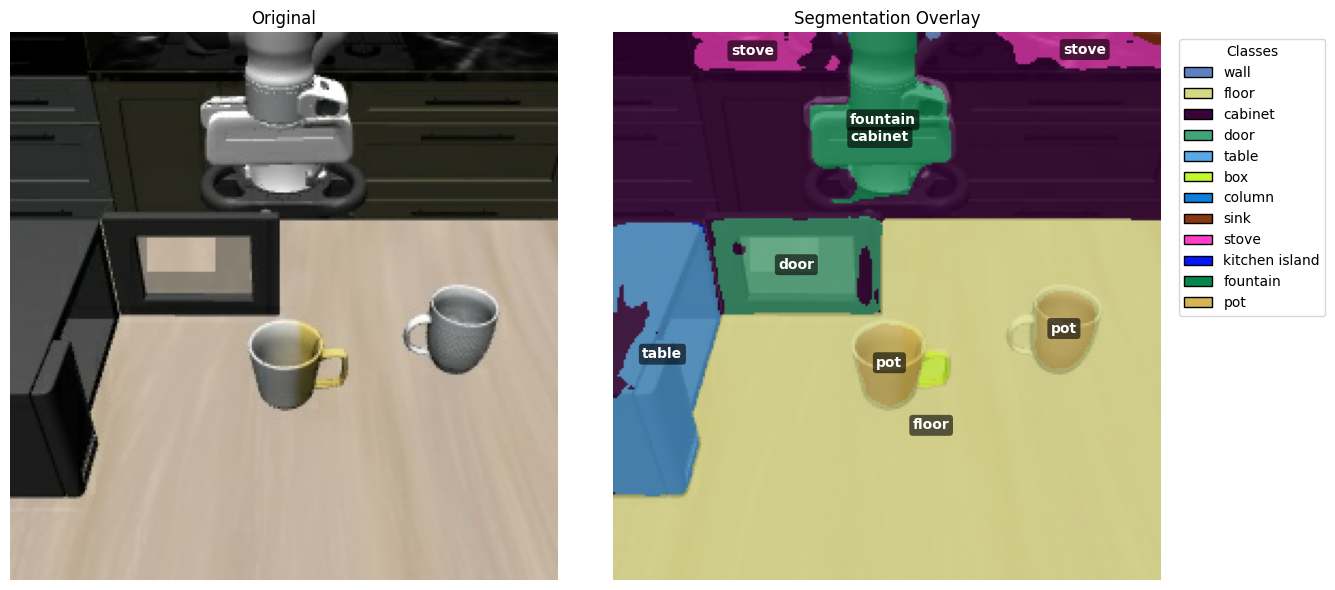

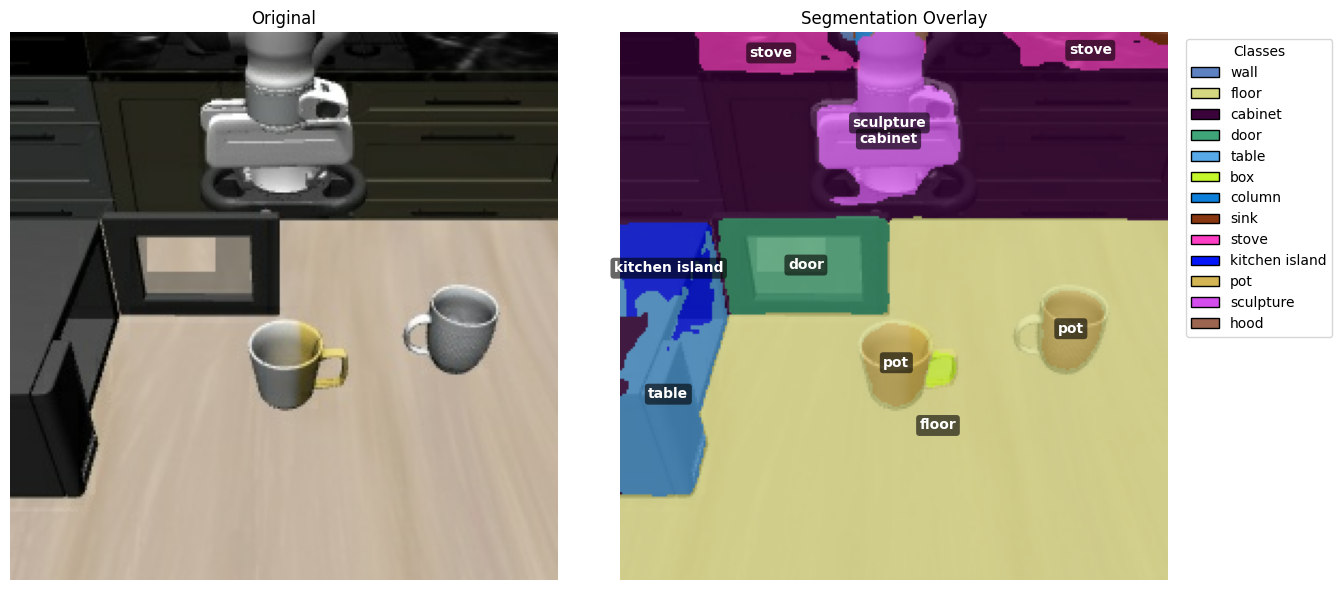

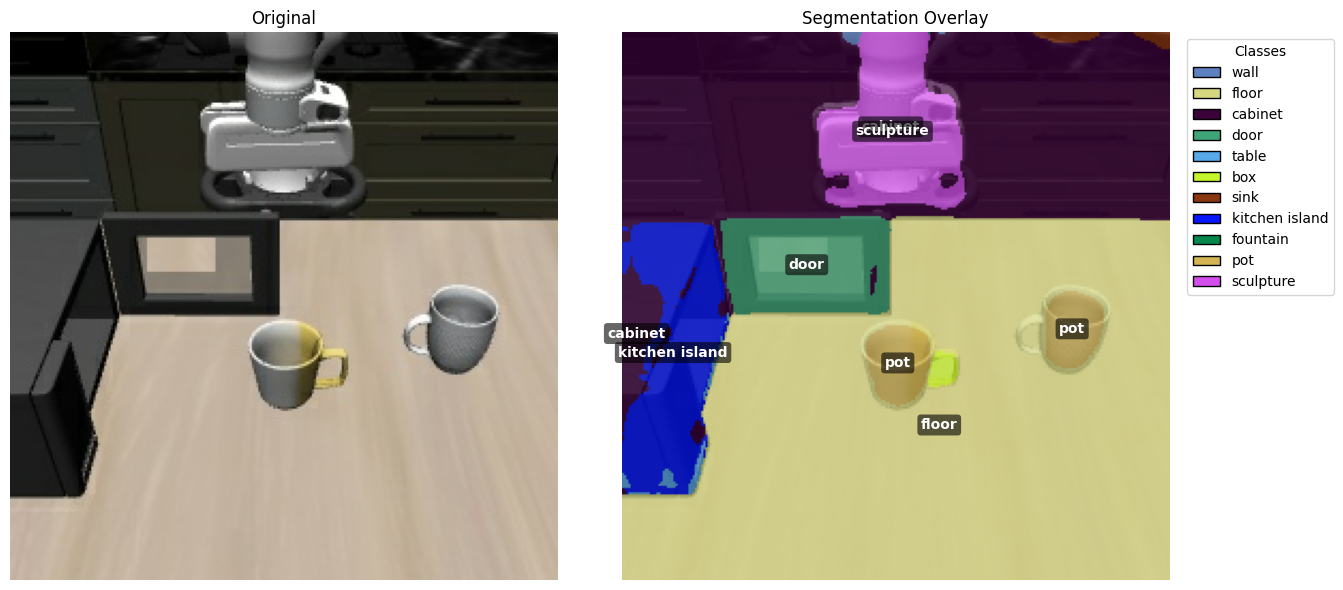

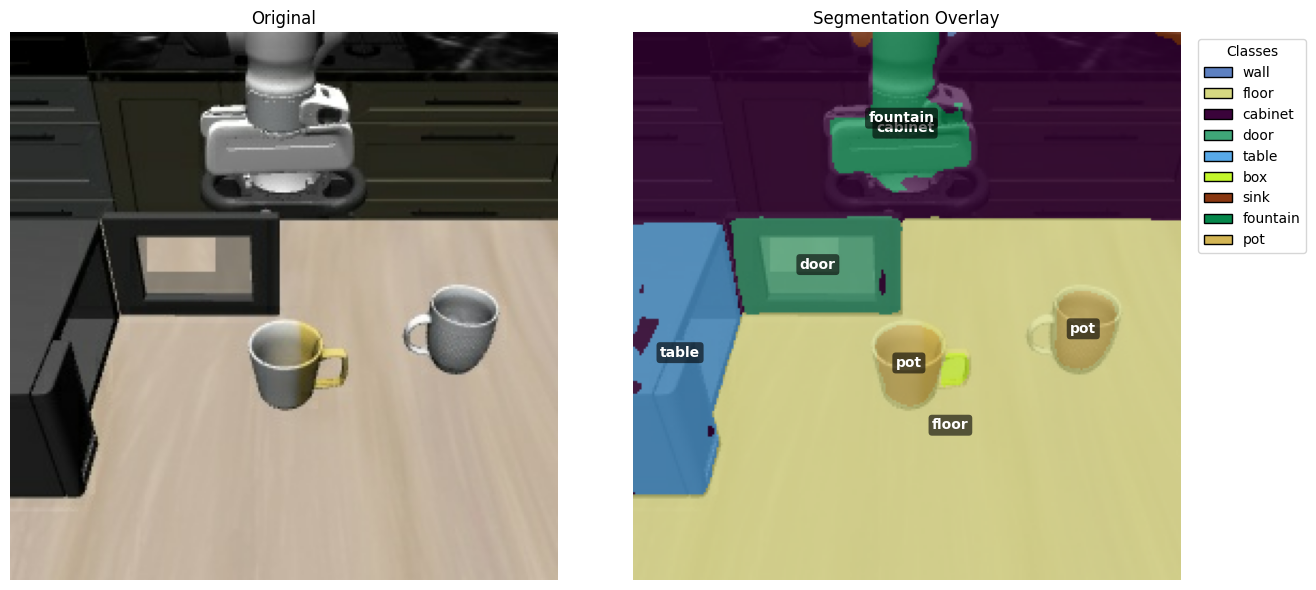

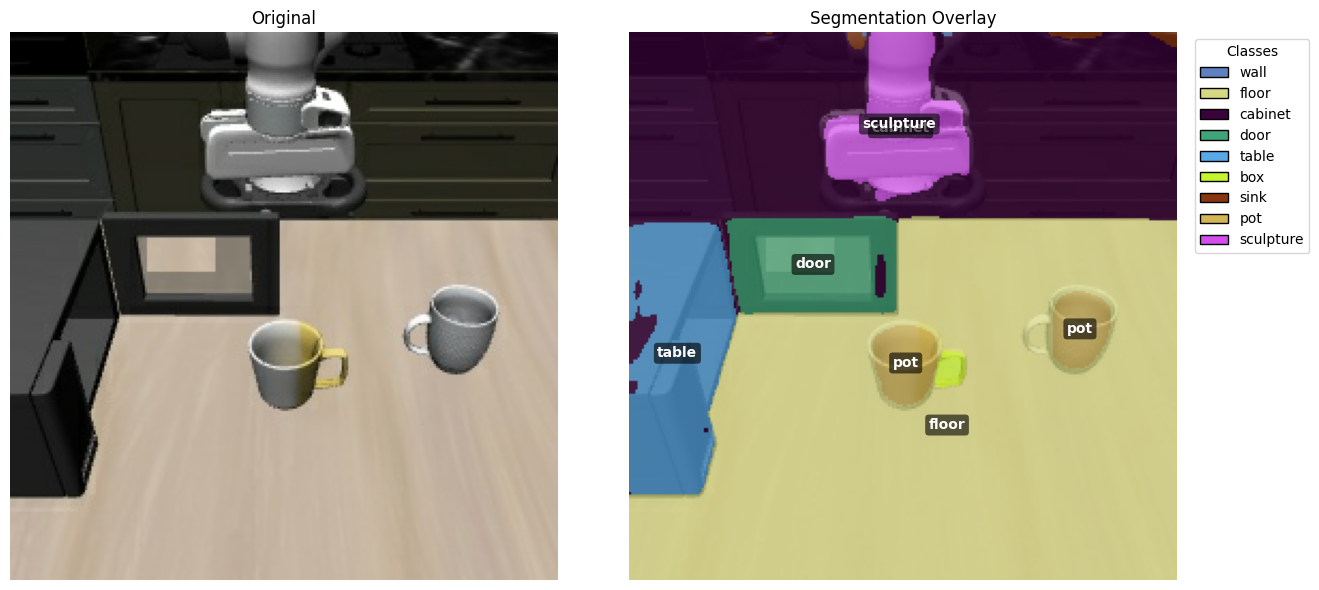

In [29]:
import torch, numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

def run_seg_with_labels(model, image, processor, min_region_px=500, alpha=0.7, seed=0):
    model.eval()
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Get an HxW array of class ids for this image
    seg = processor.post_process_semantic_segmentation(
        outputs=outputs,
        target_sizes=[image.size[::-1]]  # (H, W)
    )[0].cpu().numpy()  # shape (H, W)

    id2label = dict(model.config.id2label)
    num_classes = len(id2label)

    rng = np.random.default_rng(seed)
    colors = rng.integers(0, 255, size=(num_classes, 3), dtype=np.uint8)
    if 0 in id2label and id2label[0].lower() in {"background", "bg"}:
        colors[0] = np.array([200, 200, 200], dtype=np.uint8)

    base = np.asarray(image.convert("RGB"))
    seg_rgb = colors[seg]
    overlay = (alpha * seg_rgb + (1 - alpha) * base).astype(np.uint8)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].set_title("Original")
    ax[0].imshow(image); ax[0].axis("off")

    ax[1].set_title("Segmentation Overlay")
    ax[1].imshow(overlay); ax[1].axis("off")

    unique_ids = np.unique(seg)
    legend_handles = []
    for cid in unique_ids:
        label_name = id2label.get(int(cid), f"id {cid}")
        color = colors[int(cid)] / 255.0
        legend_handles.append(Patch(facecolor=color, edgecolor="black", label=label_name))
    ax[1].legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1.02, 1.0), title="Classes")

    # optional centroids
    from scipy.ndimage import label as cc_label, center_of_mass
    for cid in unique_ids:
        if id2label.get(int(cid), "").lower() in {"background", "bg"}:
            continue
        comp, n = cc_label((seg == cid).astype(np.uint8))
        for k in range(1, n + 1):
            m = (comp == k)
            if m.sum() < min_region_px:
                continue
            cy, cx = center_of_mass(m)
            ax[1].text(float(cx), float(cy), id2label.get(int(cid), str(cid)),
                       fontsize=10, weight="bold", ha="center", va="center",
                       color="white", bbox=dict(boxstyle="round,pad=0.25", fc="black", ec="none", alpha=0.6))

    plt.tight_layout()
    plt.show()
    return seg

# Example init
ckpt3 = "facebook/mask2former-swin-large-ade-semantic"
processor3 = AutoImageProcessor.from_pretrained(ckpt3)
model3 = Mask2FormerForUniversalSegmentation.from_pretrained(ckpt3)

# Example loop over your dataframe
for i in range(5, 10):
    image = Image.open(BytesIO(df["observation.images.image"][i]["bytes"])).convert("RGB")
    _ = run_seg_with_labels(model3, image, processor3)
